In [1]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import numpy as np
import pyBigWig
import scipy

from modisco.visualization import viz_sequence
import keras.backend as K

Using TensorFlow backend.


In [4]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll
import matplotlib.pyplot as plt

In [5]:
# local
#sys.path.append("/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/")
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/srv/scratch/anusri/chrombpnet_paper/check_footprints/one_hot.py'>

In [6]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
gc_neg_peaks =  pd.read_csv("/srv/scratch/anusri/chrombpnet_paper/GM12878/negatives_data/bpnet.inputs.all.negatives.bed", # these are non-peaks for fibroblast scATAC pseudo-bulk
                           sep='\t',
                           names=["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"])
print(gc_neg_peaks.shape)
gc_neg_peaks.head()

(189913, 10)


,chr,start,end,1,2,3,4,5,6,summit
0,chr17,48380357,48380359,.,2,.,.,.,.,1
1,chr11,19780957,19780959,.,2,.,.,.,.,1
2,chr5,57455157,57455159,.,2,.,.,.,.,1
3,chr11,20144857,20144859,.,2,.,.,.,.,1
4,chr2,240777257,240777259,.,2,.,.,.,.,1


In [10]:
gc_neg_peaks = gc_neg_peaks.sample(n=25000, replace=True, random_state=1)
print(gc_neg_peaks.shape)




(25000, 10)


In [11]:
train_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]!="chr1")&(gc_neg_peaks["chr"]!="chr2")]
val_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]=="chr2")]
test_peaks = gc_neg_peaks[(gc_neg_peaks["chr"]=="chr1")]






In [12]:
train_peaks.shape[0] + val_peaks.shape[0] + test_peaks.shape[0]





25000

In [13]:
fibr_45_bw = pyBigWig.open("/srv/scratch/anusri/chrombpnet_paper/GM12878/data_ATAC_4_5/shifted.sorted.bam.bpnet.unstranded.bw") # +4/-5 shifted
fibr_44_bw = pyBigWig.open("/srv/scratch/anusri/chrombpnet_paper/GM12878/data/shifted_4_4.sorted.bam.bpnet.unstranded.bw") # +4/-4 shifted




In [14]:
def get_cts(bw, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(np.nan_to_num(bw.values(r['chr'], 
                                            r['start']+r['summit'] - width//2,
                                            r['start'] + r['summit'] + width//2)))
        
    return np.array(vals)

In [15]:
def get_seq(genome, peaks_df, width=2000):
    vals = []
    for i, r in peaks_df.iterrows():
        vals.append(str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)]))
        
    return one_hot.dna_to_one_hot(vals)

In [16]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [17]:
train_45_cts = get_cts(fibr_45_bw, train_peaks)
val_45_cts = get_cts(fibr_45_bw, val_peaks)
test_45_cts = get_cts(fibr_45_bw, test_peaks)

train_44_cts = get_cts(fibr_44_bw, train_peaks)
val_44_cts = get_cts(fibr_44_bw, val_peaks)
test_44_cts = get_cts(fibr_44_bw, test_peaks)






In [18]:
train_seqs = get_seq(hg38, train_peaks)
val_seqs = get_seq(hg38, val_peaks)
test_seqs = get_seq(hg38, test_peaks)





In [19]:
train_seqs.shape


(20443, 2000, 4)

In [20]:
def simple_model():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(1, 100, padding='same')(inp)
    x = tf.keras.layers.Flatten()(x)
    
    return tf.keras.Model(inputs=inp, outputs=x)





In [21]:
def get_jsd(preds, cts, min_sum=10):
    return np.array([scipy.spatial.distance.jensenshannon(x,y) for x,y in zip(preds, cts) \
                     if y.sum()>min_sum])






In [22]:
model_45 = simple_model()
model_44 = simple_model()





In [24]:
model_45.compile(
    optimizer="adam",
    loss=multinomial_nll,
)

model_44.compile(
    optimizer="adam",
    loss=multinomial_nll,
)





In [25]:
model_45.fit(train_seqs,
          train_45_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_45_cts),
          shuffle=True)






Epoch 1/50
20/20 [==============================] - 2s 94ms/step - loss: 448.3077 - val_loss: 443.3629
Epoch 2/50
20/20 [==============================] - 1s 52ms/step - loss: 435.7978 - val_loss: 432.9180
Epoch 3/50
20/20 [==============================] - 1s 55ms/step - loss: 426.7965 - val_loss: 425.3575
Epoch 4/50
20/20 [==============================] - 1s 52ms/step - loss: 420.1828 - val_loss: 419.6510
Epoch 5/50
20/20 [==============================] - 1s 54ms/step - loss: 415.0970 - val_loss: 415.1791
Epoch 6/50
20/20 [==============================] - 1s 55ms/step - loss: 411.0681 - val_loss: 411.5629
Epoch 7/50
20/20 [==============================] - 1s 51ms/step - loss: 407.7836 - val_loss: 408.5990
Epoch 8/50
20/20 [==============================] - 1s 59ms/step - loss: 405.0831 - val_loss: 406.1537
Epoch 9/50
20/20 [==============================] - 1s 57ms/step - loss: 402.8527 - val_loss: 404.1247
Epoch 10/50
20/20 [==============================] - 1s 57ms/step - loss:

In [26]:
model_44.fit(train_seqs,
          train_44_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_44_cts),
          shuffle=True)




Epoch 1/50
20/20 [==============================] - 1s 63ms/step - loss: 440.1840 - val_loss: 433.9030
Epoch 2/50
20/20 [==============================] - 1s 47ms/step - loss: 425.0840 - val_loss: 421.0282
Epoch 3/50
20/20 [==============================] - 1s 45ms/step - loss: 413.6982 - val_loss: 411.1599
Epoch 4/50
20/20 [==============================] - 1s 42ms/step - loss: 404.8238 - val_loss: 403.2995
Epoch 5/50
20/20 [==============================] - 1s 46ms/step - loss: 397.6442 - val_loss: 396.8087
Epoch 6/50
20/20 [==============================] - 1s 45ms/step - loss: 391.6499 - val_loss: 391.3276
Epoch 7/50
20/20 [==============================] - 1s 43ms/step - loss: 386.5611 - val_loss: 386.6202
Epoch 8/50
20/20 [==============================] - 1s 40ms/step - loss: 382.1760 - val_loss: 382.5573
Epoch 9/50
20/20 [==============================] - 1s 39ms/step - loss: 378.3794 - val_loss: 379.0439
Epoch 10/50
20/20 [==============================] - 1s 39ms/step - loss:

In [27]:
np.median(get_jsd(softmax(model_45.predict(test_seqs)), test_45_cts))


0.7363174959904892

In [28]:
np.median(get_jsd(softmax(model_44.predict(test_seqs)), test_44_cts))



0.702166563356327

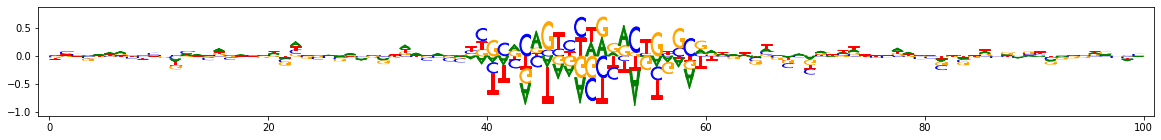

In [29]:
viz_sequence.plot_weights(model_44.layers[1].get_weights()[0][:,:,0], subticks_frequency=20)


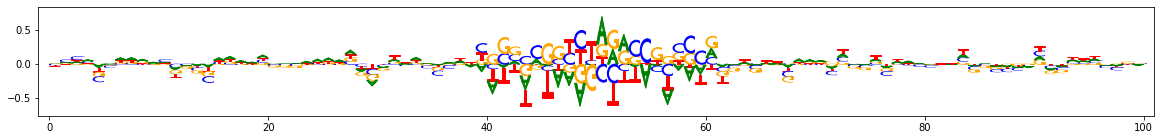

In [30]:
viz_sequence.plot_weights(model_45.layers[1].get_weights()[0][:,:,0], subticks_frequency=20)


In [31]:
def model_3conv():
    inp = tf.keras.Input((2000,4))
    x = tf.keras.layers.Conv1D(50, 100, padding='same')(inp)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv1D(20, 100, padding='same')(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv1D(2, 100, padding='same')(x)
    x = tf.keras.layers.Dense(1, activation='relu')(x)
    
    x = tf.keras.layers.Flatten()(x)

    return tf.keras.Model(inputs=inp, outputs=x)

In [32]:
model_complex = model_3conv()


In [33]:
model_complex.compile(
    optimizer="adam",
    loss=multinomial_nll,
)

In [34]:
model_complex.fit(train_seqs,
          train_44_cts,
         batch_size=1024,
         epochs=50,
         validation_data=(val_seqs, val_44_cts),
          shuffle=True)

Epoch 1/50
20/20 [==============================] - 14s 685ms/step - loss: 381.0378 - val_loss: 361.4608
Epoch 2/50
20/20 [==============================] - 10s 516ms/step - loss: 357.5019 - val_loss: 357.8331
Epoch 3/50
20/20 [==============================] - 11s 526ms/step - loss: 354.4250 - val_loss: 355.5355
Epoch 4/50
20/20 [==============================] - 10s 519ms/step - loss: 352.5385 - val_loss: 353.8347
Epoch 5/50
20/20 [==============================] - 11s 527ms/step - loss: 350.6487 - val_loss: 351.6697
Epoch 6/50
20/20 [==============================] - 11s 535ms/step - loss: 348.2450 - val_loss: 348.7541
Epoch 7/50
20/20 [==============================] - 11s 534ms/step - loss: 345.3134 - val_loss: 345.8817
Epoch 8/50
20/20 [==============================] - 11s 537ms/step - loss: 342.8282 - val_loss: 343.7518
Epoch 9/50
20/20 [==============================] - 11s 538ms/step - loss: 341.1284 - val_loss: 342.3696
Epoch 10/50
20/20 [==============================] - 11

In [35]:
np.median(get_jsd(softmax(model_complex.predict(test_seqs)), test_44_cts))


0.6783541936729428

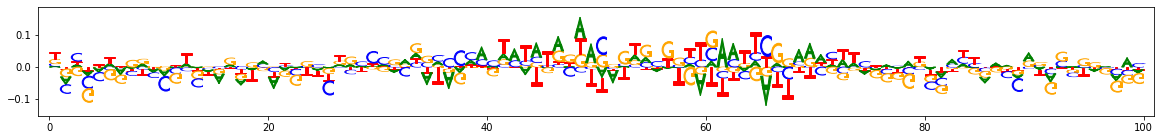

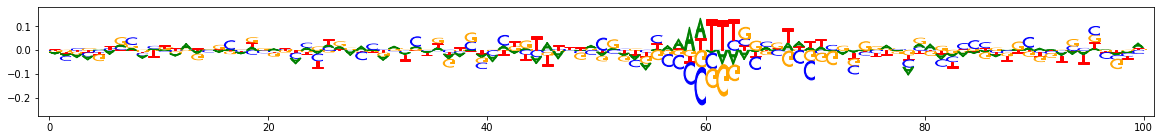

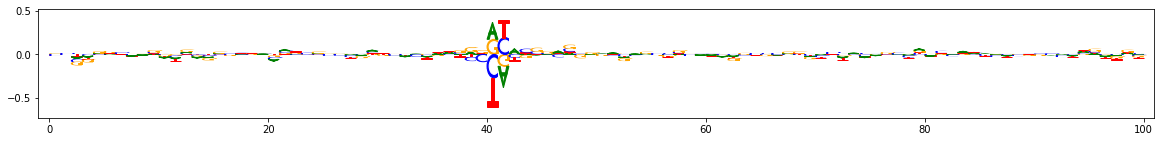

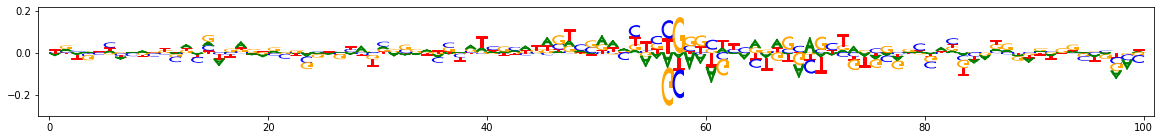

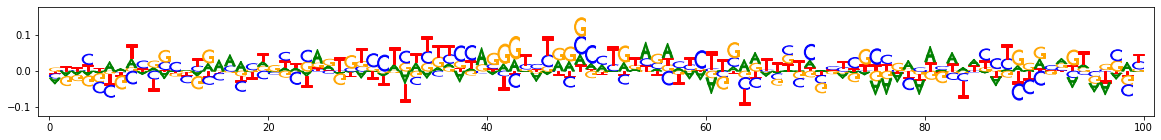

In [36]:
for i in [1,2,8,11,16]:
    viz_sequence.plot_weights(model_complex.layers[1].get_weights()[0][:,:,i], subticks_frequency=20)